# Maximumm Likelihood Estimation for Poisson Distribution

The context can be found in exercise 7.7 of [Boyd's _convex optimization_](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf), pp. 394-395.
We refer to the therementioned detection of emitted photons from $n$ sources by $m$ detectors.

A maximum likelihood estimation of the joint poisson distributions $y_1, \ldots , y_m$ relies on their stochastical independence.
<br>
While it makes sense to assume that per detector $d_j$ the $y_{j1}, \ldots, y_{jn}$ are stochastically independent, 
the stochastical independence of the counts $y_j$ of detected photons by detector $d_j$ is disputable:
<br>
If for example $m-1$ detectors exhibit a large photon count, this is a strong indication that many photons were emitted by the sources.
<br>
Therefore, it is sane to believe that the remaining detector will have a large photon detection count too.
But this supports the idea that the random variables $y_1, \ldots, y_m$ are *not* stochastically independent.

In this notebook, we will give numerical evidence for this.

In [1]:
import numpy as np

from scipy.stats import poisson, binom

class Tomography:

    n, m = None, None
    mus = None # shape = ( n , )
    P = None   # shape = ( m , n )
    xi = None  # shape = ( trial_cnt, n )
    yji = None # shape = ( trial_cnt, m , n )
    yj = None  # shape = ( trial_cnt, m )

    def __init__(self, n=3, m=2, mus=None, mus_thres=None, seed=0):

        self.rng = np.random.default_rng(seed)

        self.n = n # number of sources
        self.m = m # number of detectors
        if mus is None:
            mus_thres = mus_thres or 100
            self.mus = self.rng.uniform(0, mus_thres, size=n)
        elif len(mus) == 1:
            self.mus = np.repeat(mus, n)
        else:
            assert len(mus) == n
            self.mus = mus

        self._P()

        self.lambdas = self.P @ self.mus

    def run_trials(self, trial_cnt=10, seed=0):
        """
        Trial procedure
        Do the following for `trial_cnt` many times:
            1. Each of the n sources emits x_i = poisson.rvs(mu_i) many photons, ...
            2. of which detector j detects y_ji = binom.rvs(n=x_i, p=p_ji)
        """
        rng = np.random.default_rng(seed)
        
        # `trial_cnt` many photon emissions from the n sources
        # shape = ( trial_cnt, n )
        self.xi = np.array([
            poisson.rvs(self.mus, random_state=rng)
            for _ in range(trial_cnt)
        ])

        # shape = ( trial_cnt , m , n )
        self.yji = np.array([
            [
                binom.rvs(n=self.xi[trial], p=pj, random_state=rng)
                for pj in self.P
            ]
            for trial in range(trial_cnt)
        ])
        
        # shape = ( trial_cnt , m )
        self.yj = np.sum(self.yji, axis=2)

    def abs_count(self, subset=None):
        """
        Frequencies of occurences yj = kj for kj in subset
        """

        abs_cnt = dict()
        subset = subset or range(self.m)
        for y in self.yj[:, subset]:
            combo = tuple(y)
            if combo in abs_cnt.keys() :
                abs_cnt[combo] += 1
            else:
                abs_cnt[combo] = 1
        
        return abs_cnt

    def rel_count(self, subset=None):
        """
        Frequencies of occurences yj = kj for kj in subset
        """

        trial_cnt = self.yj.shape[0]
        abs_cnt = self.abs_count(subset=subset)

        rel_cnt = dict()

        for combo, count in abs_cnt.items():
            rel_cnt[combo] = count / trial_cnt
        
        return rel_cnt

    def _P(self):
        """
        Create detection rate matrix P with np.sum(P, axis=0) << 1
        The latter assures that P(any detector detects i | i emitted) ≤ 1
        """
        P = np.array([ self.rng.uniform(0, 1, size=self.m+1) for _ in range(self.n) ])
        normalizers = np.sum(P, axis=1)
        self.P = np.array([ p[:-1] / normalizer for p, normalizer in zip(P, normalizers) ]).T



## Written Report: Joint Probability vs Product of Marginals

$$
    \dfrac 
        {P(y_{0} = k_0, \ldots , y_{m-1} = k_{m-1})} 
        {P(y_{0} = k_0) \cdot \ldots \cdot P(y_{m-1} = k_{m-1})} 
    \overset{?}{\approx} 1
$$

In [2]:
n, m = 10, 2
tmgy = Tomography(n=n, m=m, mus_thres=10, seed=3)

trial_cnt = 1000
tmgy.run_trials(trial_cnt=trial_cnt, seed=3)

abs_count_all = tmgy.abs_count()
abs_count_marginal = [ tmgy.abs_count(subset=[i]) for i in range(m) ]

rel_count_all = tmgy.rel_count()
rel_count_marginal = [ tmgy.rel_count(subset=[i]) for i in range(m) ]

prod_marginal = {
    combo: np.prod( [ rel_count_marginal[i][(k, )] for i, k in zip(range(m), combo) ] )
    for combo in rel_count_all.keys()
}

joint_over_prod = np.array( [ rel_cnt / prod_marginal[combo] for combo, rel_cnt in rel_count_all.items() ] )
max_joint_over_prod = np.max(joint_over_prod)
min_joint_over_prod = np.min(joint_over_prod)
average_rel_error = np.average(joint_over_prod)
combos = np.array( [ combo for combo in rel_count_all.keys() ] )
combo_cnt = len(combos)

print(f'''Report:

light emitters:                {n}
detectors:                     {m}
poisson params at emitters:    {np.round( tmgy.mus, 4 )}
poisson params at detectors:   {np.round( tmgy.lambdas, 4 )}

trial count:                   {trial_cnt}
number of different combos:    {combo_cnt}

maximum ratio between 
product of marginal freqs 
and joint freq:                {max_joint_over_prod}

minimum ratio between 
product of marginal freqs 
and joint freq:                {min_joint_over_prod}

average ratio between
product of marginal freqs 
and joint freq:                {average_rel_error}

''')

Report:

light emitters:                10
detectors:                     2
poisson params at emitters:    [0.8565 2.3681 8.0127 5.8216 0.9413 4.3313 4.7905 1.5974 7.3458 1.1367]
poisson params at detectors:   [ 7.2323 13.8439]

trial count:                   1000
number of different combos:    203

maximum ratio between 
product of marginal freqs 
and joint freq:                52.63157894736842

minimum ratio between 
product of marginal freqs 
and joint freq:                0.1994415636218588

average ratio between
product of marginal freqs 
and joint freq:                2.385283971424313




## Empirical Comparison Joint Probability vs. Product of Marginals

$$
    \dfrac 
        {P(y_{j_0} = k_{j_0}, y_{j_1} = k_{j_1})} 
        {P(y_{j_0} = k_{j_0}) \cdot P(y_{j_1} = k_{j_1})} 
    \overset{?}{\approx} 1
$$

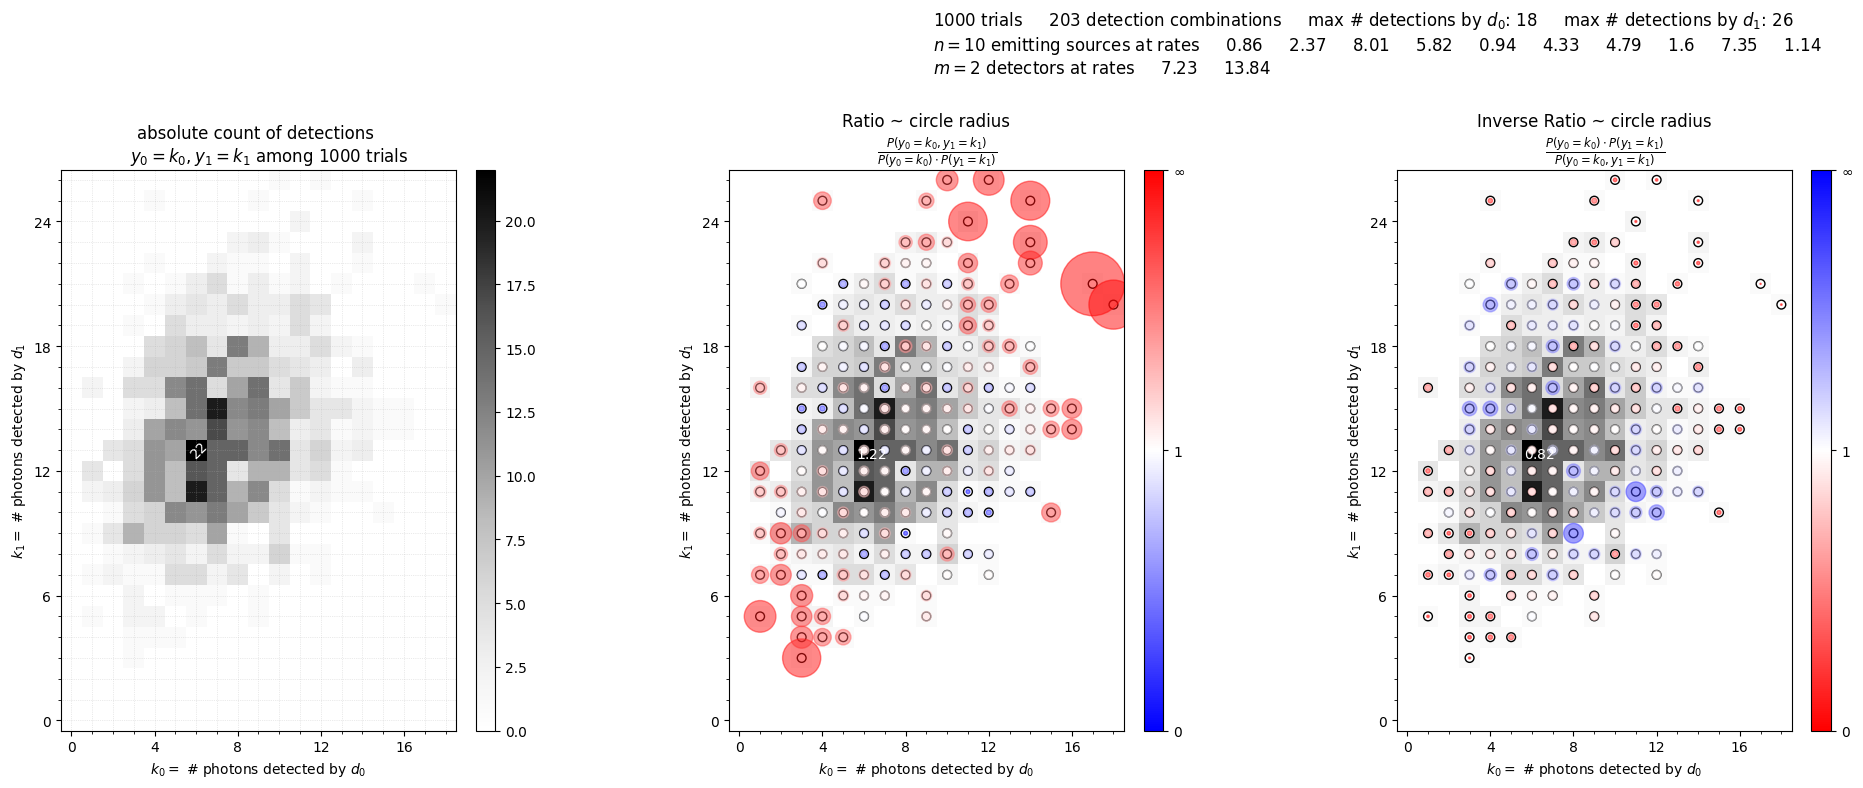

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator

j0, j1 = 0, 1
unique_combos = np.unique(combos[:, [j0, j1]], axis=0)

max_j0 = np.max(unique_combos[:, 0])
max_j1 = np.max(unique_combos[:, 1])

abs_cnt_j0_j1 = tmgy.abs_count(subset=[j0, j1])
abs_cnt_j0    = tmgy.abs_count(subset=[j0])
abs_cnt_j1    = tmgy.abs_count(subset=[j1])

major_j0, minor_j0 = np.ceil(max_j0 / 5), 1
major_j1, minor_j1 = np.ceil(max_j1 / 5), 1

colorbar_metrics = [1.05, 0, 0.05, 1]
reds = plt.get_cmap('bwr')
blues = plt.get_cmap('bwr_r')
greys = plt.get_cmap('Greys')
color_fcn = lambda x: np.power(.5, x)
s = 40

joint_over_prod_j0_j1 = np.array([
    abs_cnt_j0_j1[(k0, k1)] * trial_cnt / ( abs_cnt_j0[(k0,)] * abs_cnt_j1[(k1,)] )
    for k0, k1 in unique_combos
])


d = 1 # compute ratio for the largest d empirical detection combinations

abs_cnt_j0_j1_unique_combos = np.array([ abs_cnt_j0_j1[(k0, k1)] for k0, k1 in unique_combos ])

d_most_freq_ind = np.argsort(abs_cnt_j0_j1_unique_combos)[-d:]
d_most_freq_combo = unique_combos[d_most_freq_ind, :]


fig, axes = plt.subplots(1, 3, figsize=(20, 8))

fig.suptitle(f'''{trial_cnt} trials     {combo_cnt} detection combinations     max # detections by $d_{{{j0}}}$: {max_j0}     max # detections by $d_{{{j1}}}$: {max_j1}
$ n = {n} $ emitting sources at rates     {"     ".join([ str(r) for r in np.round(tmgy.mus, 2) ])}
$ m = {m} $ detectors at rates     {"     ".join([ str(r) for r in np.round(tmgy.lambdas, 2) ])}
''', ha='left')


## ============================================================ ##
#                    absolute detection counts                   #
## ============================================================ ##

ax = axes[0]
ax.set(
    title=f'''absolute count of detections 
    $y_{{{j0}}} = k_{{{j0}}}, y_{{{j1}}} = k_{{{j1}}}$ among ${trial_cnt}$ trials''',
    xlabel=f'$k_{{{j0}}} = $ # photons detected by $d_{{{j0}}}$',
    ylabel=f'$k_{{{j1}}} = $ # photons detected by $d_{{{j1}}}$',
    aspect=1
)
cls = greys
ax.xaxis.set_major_locator(MultipleLocator(major_j0))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(minor_j0))

ax.yaxis.set_major_locator(MultipleLocator(major_j1))
ax.yaxis.set_major_formatter('{x:.0f}')
ax.yaxis.set_minor_locator(MultipleLocator(minor_j1))

hist2d = ax.hist2d(tmgy.yj[:, j0], tmgy.yj[:, j1], range=([-.5, max_j0 + .5], [-.5, max_j1 + .5]), bins=(max_j0+1, max_j1+1), cmap=cls)
ax.grid(axis='both', which='both', linewidth=.5, linestyle='dotted', alpha=.5)
for combo, ind in zip(d_most_freq_combo, d_most_freq_ind):
    ax.text(combo[0] - .4, combo[1] - .4, f'${abs_cnt_j0_j1_unique_combos[ind]}$', color='white', rotation=45)
fig.colorbar(
    plt.cm.ScalarMappable(
        cmap=cls, 
        norm=mpl.colors.Normalize(vmin=0, vmax=max(abs_cnt_j0_j1.values()))
    ), 
    cax=ax.inset_axes(colorbar_metrics)
)

## ============================================================ ##
#         Joint Probability / Product of Probabilities           #
## ============================================================ ##

ax = axes[1]
ax.set(
    title=f'''Ratio ~ circle radius
    $\\frac {{P(y_{{{j0}}} = k_0, y_{{{j1}}} = k_1)}} {{P(y_{{{j0}}} = k_0) \\cdot P(y_{{{j1}}} = k_1)}} $''',
    xlabel=f'$k_{{{j0}}} = $ # photons detected by $d_{{{j0}}}$',
    ylabel=f'$k_{{{j1}}} = $ # photons detected by $d_{{{j1}}}$',
    aspect=1,
)
cls = reds
ax.xaxis.set_major_locator(MultipleLocator(major_j0))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(minor_j0))

ax.yaxis.set_major_locator(MultipleLocator(major_j1))
ax.yaxis.set_major_formatter('{x:.0f}')
ax.yaxis.set_minor_locator(MultipleLocator(minor_j1))

ax.hist2d(tmgy.yj[:, j0], tmgy.yj[:, j1], range=([-.5, max_j0 + .5], [-.5, max_j1 + .5]), bins=(max_j0+1, max_j1+1), cmap=greys)
ax.scatter(unique_combos[:, 0], unique_combos[:, 1], s=s*np.ones(len(unique_combos)), linewidth=1, color='white', edgecolors='k')
scatter = ax.scatter(unique_combos[:, 0], unique_combos[:, 1], s=s*joint_over_prod_j0_j1, color=cls(color_fcn(1 / joint_over_prod_j0_j1)), alpha=.5)
for combo, ind in zip(d_most_freq_combo, d_most_freq_ind):
    ax.text(combo[0] - .4, combo[1] - .4, f'${np.round(joint_over_prod_j0_j1[ind], 2)}$', color='white')
fig.colorbar(
    plt.cm.ScalarMappable(
        cmap=cls, 
        norm=mpl.colors.Normalize(vmin=0, vmax=1)
    ),
    cax=ax.inset_axes(colorbar_metrics)
).ax.get_yaxis().set(
    ticks=[0, .5, 1],
    ticklabels=['$0$', '$1$', '$\infty$'],
)


## ============================================================ ##
#         Product of Probabilities / Joint Probability           #
## ============================================================ ##

ax = axes[2]
ax.set(
    title=f'''Inverse Ratio ~ circle radius
    $ \\frac {{P(y_{{{j0}}} = k_0) \\cdot P(y_{{{j1}}} = k_1)}} {{P(y_{{{j0}}} = k_0, y_{{{j1}}} = k_1)}} $''',
    xlabel=f'$k_{{{j0}}} = $ # photons detected by $d_{{{j0}}}$',
    ylabel=f'$k_{{{j1}}} = $ # photons detected by $d_{{{j1}}}$',
    aspect=1,
)
cls = blues
ax.xaxis.set_major_locator(MultipleLocator(major_j0))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(minor_j0))

ax.yaxis.set_major_locator(MultipleLocator(major_j1))
ax.yaxis.set_major_formatter('{x:.0f}')
ax.yaxis.set_minor_locator(MultipleLocator(minor_j1))

ax.hist2d(tmgy.yj[:, j0], tmgy.yj[:, j1], range=([-.5, max_j0 + .5], [-.5, max_j1 + .5]), bins=(max_j0+1, max_j1+1), cmap=greys)
ax.scatter(unique_combos[:, 0], unique_combos[:, 1], s=s*np.ones(len(unique_combos)), linewidth=1, color='white', edgecolors='k')
scatter = ax.scatter(unique_combos[:, 0], unique_combos[:, 1], s=s/joint_over_prod_j0_j1, color=cls(color_fcn(joint_over_prod_j0_j1)), alpha=.5)
for combo, ind in zip(d_most_freq_combo, d_most_freq_ind):
    ax.text(combo[0] - .4, combo[1] - .4, f'${np.round(1 / joint_over_prod_j0_j1[ind], 2)}$', color='white')
fig.colorbar(
    plt.cm.ScalarMappable(
        cmap=cls, 
        norm=mpl.colors.Normalize(vmin=0, vmax=1)
    ),
    cax=ax.inset_axes(colorbar_metrics)
).ax.get_yaxis().set(
    ticks=[0, .5, 1],
    ticklabels=['$0$', '$1$', '$\infty$'],
)

fig.tight_layout()

plt.show()

# Conclusions

The colors and sizes of the circle in the middle and right diagram measure the deviation of the ratios from $1$. 
The color coded deviation is given by the formulas
$$
    \dfrac 
        {P(y_{j_0} = k_{j_0}, y_{j_1} = k_{j_1})} 
        {P(y_{j_0} = k_{j_0}) \cdot P(y_{j_1} = k_{j_1})} 
    = -\frac{1}{\log_2(c)}

    \qquad\qquad

    \dfrac 
        {P(y_{j_0} = k_{j_0}) \cdot P(y_{j_1} = k_{j_1})} 
        {P(y_{j_0} = k_{j_0}, y_{j_1} = k_{j_1})} 
    = -\log_2(c)
$$
resp. where $ c \in [0, 1] $. Hence,
* white encodes a ratio of exactly $1$
* red encodes a ratio in $ (1, \infty) $.
* blue encodes an inverse ratio in $ (1, \infty) $, i. e. a ratio in $ (0, 1) $

The left diagram shows the absolute counts of the detection combinations. 
It is also laid behind the other two diagrams so as to see which circles are expressive at all:
A light area means lower total occurences of a detection combination in the trial. 
Hence, their empirical probabilities will *not* accurately reflect the actual probabilities,
meaning that those data points are not expressive.
This seems to be the reason why at light areas the circles are so large.

Still, even at dark areas (i. e. where we may expect the empirical probability to be close to the actual probability) 
the circles are not white. 
This supports our initial hypothesis that the random variables $y_{j_0}$ and $y_{j_1}$ are not stochastically independent.

Furthermore, if the random variables $y_{j_0}$ and $y_{j_1}$ were stochastically independent, 
the plot in the detection histogram must not show any correlation between the two random variables. 
However, for high photon emissions rates and many emitting sources, a correlation in the histogram is clearly visible.